In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
# from xgboost import XGBRegressor
from catboost import CatBoostRegressor
# from lightgbm import LGBMRegressor
from scipy.fftpack import fft
from sklearn.preprocessing import PowerTransformer, TargetEncoder
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import STL
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import copy
from pytorch_forecasting import TimeSeriesDataSet
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from torchmetrics import MeanSquaredError
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer

In [ ]:
RANDOM_STATE = 23
N_TRIALS = 25
FILE_PATH = 'currency_raw.parquet'
FILE_TYPE = 'currency'
TICKER = 'USDRUB'
TICKER_TYPE = 'Open'
WINDOW_SIZE = 10

In [ ]:

def preprocess_time_series(
    df: pd.DataFrame,
    target: str,
    transformers: dict = None,
    do_scale: bool = True,
    do_diff: bool = True,
    do_yeo_johnson: bool = True,
    do_window_normalizing: bool = True,
    window_size: int = 10,
    do_encode: bool = True,
    is_train: bool = False
):
    """
    –ü—Ä–µ–¥–æ–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ—Ç –≤—Ä–µ–º–µ–Ω–Ω–æ–π —Ä—è–¥ –¥–ª—è —Å—Ç–æ–ª–±—Ü–∞ 'target' –≤ DataFrame, –∏–∑–º–µ–Ω—è—è —Ç–æ–ª—å–∫–æ —ç—Ç–æ—Ç —Å—Ç–æ–ª–±–µ—Ü,
    —Å –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç—å—é –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è –∏—Å—Ö–æ–¥–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π. –£—á–∏—Ç—ã–≤–∞–µ—Ç data leakage.

    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    ----------
    df : pd.DataFrame
        –ò—Å—Ö–æ–¥–Ω—ã–π DataFrame.
    target : str
        –ù–∞–∑–≤–∞–Ω–∏–µ —Å—Ç–æ–ª–±—Ü–∞, –¥–ª—è –∫–æ—Ç–æ—Ä–æ–≥–æ –≤—ã–ø–æ–ª–Ω—è—é—Ç—Å—è –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è.
    transformers : dict, optional
        –°–ª–æ–≤–∞—Ä—å —Å –æ–±—ä–µ–∫—Ç–∞–º–∏ —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–µ—Ä–æ–≤ (–∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –ø—Ä–∏ is_train=False).
    do_scale : bool, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é True
        –í—ã–ø–æ–ª–Ω—è—Ç—å –ª–∏ –º–∞—Å—à—Ç–∞–±–∏—Ä–æ–≤–∞–Ω–∏–µ.
    do_diff : bool, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é True
        –í—ã–ø–æ–ª–Ω—è—Ç—å –ª–∏ –¥–∏—Ñ—Ñ–µ—Ä–µ–Ω—Ü–∏—Ä–æ–≤–∞–Ω–∏–µ.
    do_yeo_johnson : bool, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é True
        –í—ã–ø–æ–ª–Ω—è—Ç—å –ª–∏ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ Yeo-Johnson.
    do_window_normalizing : bool, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é True
        –í—ã–ø–æ–ª–Ω—è—Ç—å –ª–∏ –æ–∫–æ–Ω–Ω—É—é –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—é.
    window_size : int, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 10
        –†–∞–∑–º–µ—Ä –æ–∫–Ω–∞ –¥–ª—è –æ–∫–æ–Ω–Ω–æ–π –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏.
    do_encode : bool
        –í—ã–ø–æ–ª–Ω—è—Ç—å –ª–∏ –∫–æ–¥–∏—Ä–æ–≤–∫—É –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤.
    is_train : bool, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é True
        –§–ª–∞–≥, —É–∫–∞–∑—ã–≤–∞—é—â–∏–π, —è–≤–ª—è—é—Ç—Å—è –ª–∏ –¥–∞–Ω–Ω—ã–µ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–º–∏.

    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    df_transformed : pd.DataFrame
        –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–Ω—ã–π DataFrame —Å —Ç–æ–ª—å–∫–æ –∏–∑–º–µ–Ω—ë–Ω–Ω—ã–º —Å—Ç–æ–ª–±—Ü–æ–º 'target'.
    transformers : dict
        –°–ª–æ–≤–∞—Ä—å —Å –æ–±—ä–µ–∫—Ç–∞–º–∏ —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–µ—Ä–æ–≤ –¥–ª—è –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è –∑–Ω–∞—á–µ–Ω–∏–π.
    """
    df_transformed = df.copy()
    ts = df_transformed[target].copy()

    if is_train:
        transformers = {}
    elif transformers is None:
        raise ValueError('–î–ª—è —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –ø–µ—Ä–µ–¥–∞—Ç—å transformers.')

    # –ú–∞—Å—à—Ç–∞–±–∏—Ä–æ–≤–∞–Ω–∏–µ.
    if do_scale:
        values = ts.values.reshape(-1, 1)

        if is_train:
            scaler = StandardScaler()
            scaled_values = scaler.fit_transform(values)
            transformers['scaler'] = scaler
        else:
            scaler = transformers['scaler']
            scaled_values = scaler.transform(values)

        ts = pd.Series(
            data=scaled_values.flatten(),
            index=ts.index,
            name=ts.name
        )

    # –î–∏—Ñ—Ñ–µ—Ä–µ–Ω—Ü–∏—Ä–æ–≤–∞–Ω–∏–µ.
    if do_diff:
        transformers['last_value'] = ts.iloc[0]
        ts = ts.diff()
        ts.dropna(inplace=True)

    # –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ Yeo-Johnson.
    if do_yeo_johnson:
        if is_train:
            pt = PowerTransformer(method='yeo-johnson', standardize=False)
            non_nan_values = ts.values[~np.isnan(ts.values)].reshape(-1, 1)
            if len(non_nan_values) > 0:
                pt.fit(non_nan_values)
            transformers['yeo_johnson'] = pt

        pt = transformers['yeo_johnson']
        transformed_values = np.full_like(ts.values, np.nan, dtype=float)
        non_nan_mask = ~np.isnan(ts.values)
        non_nan_values = ts.values[non_nan_mask].reshape(-1, 1)

        if len(non_nan_values) > 0:
            transformed_values[non_nan_mask] = pt.transform(non_nan_values).flatten()

        ts = pd.Series(transformed_values, index=ts.index, name=ts.name)

    # –û–∫–æ–Ω–Ω–∞—è –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è.
    if do_window_normalizing:
        ts_rolled = ts.rolling(window=window_size)
        rolled_mean = ts_rolled.mean()
        rolled_std = ts_rolled.std()
        transformers['rolled_mean'] = rolled_mean
        transformers['rolled_std'] = rolled_std
        transformers['window_init_values'] = ts.iloc[:window_size - 1].values.copy()

        eps = 1e-9
        ts = (ts - rolled_mean) / (rolled_std + eps)
        ts = ts[window_size - 1:]


    df_transformed[target] = ts
    df_transformed.dropna(inplace=True)

    if do_encode:
        if is_train:
            encoder = TargetEncoder(cv=3, random_state=RANDOM_STATE)
            df_transformed['ticker'] = encoder.fit_transform(X=df_transformed[['ticker']], y=ts)

            transformers['encoder'] = encoder
        else:
            encoder = transformers['encoder']
            df_transformed['ticker'] = encoder.transform(X=df_transformed[['ticker']])

    return df_transformed.set_index('Date'), transformers


def inverse_preprocess_time_series(
    ts_transformed: np.array,
    transformers: dict,
    do_scale: bool = True,
    do_diff: bool = True,
    do_yeo_johnson: bool = True,
    do_window_normalizing: bool = True,
    window_size: int = 10
) -> np.array:
    """
    –í–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ—Ç –∏—Å—Ö–æ–¥–Ω—ã–π –≤—Ä–µ–º–µ–Ω–Ω–æ–π —Ä—è–¥ –∏–∑ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–Ω–æ–≥–æ np.array,
    –∏—Å–ø–æ–ª—å–∑—É—è —Å–æ—Ö—Ä–∞–Ω—ë–Ω–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–∞—Ü–∏–π, –≤—ã–ø–æ–ª–Ω–µ–Ω–Ω—ã—Ö –≤ —Ñ—É–Ω–∫—Ü–∏–∏ preprocess_time_series.

    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    -----------
    ts_transformed : np.array
        –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–Ω—ã–π –≤—Ä–µ–º–µ–Ω–Ω–æ–π —Ä—è–¥.
    transformers : dict
        –°–ª–æ–≤–∞—Ä—å —Å —Å–æ—Ö—Ä–∞–Ω—ë–Ω–Ω—ã–º–∏ –æ–±—ä–µ–∫—Ç–∞–º–∏ –∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏ —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–∞—Ü–∏–π.
    do_scale : bool, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é True
        –í—ã–ø–æ–ª–Ω—è—Ç—å –ª–∏ –º–∞—Å—à—Ç–∞–±–∏—Ä–æ–≤–∞–Ω–∏–µ.
    do_diff : bool, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é True
        –í—ã–ø–æ–ª–Ω—è—Ç—å –ª–∏ –¥–∏—Ñ—Ñ–µ—Ä–µ–Ω—Ü–∏—Ä–æ–≤–∞–Ω–∏–µ.
    do_yeo_johnson : bool, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é True
        –í—ã–ø–æ–ª–Ω—è—Ç—å –ª–∏ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ Yeo-Johnson.
    do_window_normalizing : bool, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é True
        –í—ã–ø–æ–ª–Ω—è—Ç—å –ª–∏ –æ–∫–æ–Ω–Ω—É—é –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—é.
    window_size : int, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 10
        –†–∞–∑–º–µ—Ä –æ–∫–Ω–∞ –¥–ª—è –æ–∫–æ–Ω–Ω–æ–π –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏.

    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    np.array
        –í–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–Ω—ã–π –≤—Ä–µ–º–µ–Ω–Ω–æ–π —Ä—è–¥ –≤ –∏—Å—Ö–æ–¥–Ω—ã—Ö –µ–¥–∏–Ω–∏—Ü–∞—Ö –∏–∑–º–µ—Ä–µ–Ω–∏—è.
    """
    ts = ts_transformed.copy()

    # 1. –û–±—Ä–∞—Ç–Ω–∞—è –æ–∫–æ–Ω–Ω–∞—è –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è
    if do_window_normalizing:
        eps = 1e-9
        rolled_mean = transformers.get('rolled_mean')
        rolled_std = transformers.get('rolled_std')
        init_values = transformers.get('window_init_values', np.array([]))
        window = transformers.get('window')

        if rolled_mean is None or rolled_std is None:
            raise ValueError("–ù–µ—Ç –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –æ–±—Ä–∞—Ç–Ω–æ–π –æ–∫–æ–Ω–Ω–æ–π –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏.")

        ts = ts * (rolled_std.values[window_size - 1:window_size - 1 + len(ts)] + eps) + rolled_mean.values[window_size - 1:window_size - 1 + len(ts)]
        ts = np.concatenate([init_values, ts])

    # 2. –û–±—Ä–∞—Ç–Ω–æ–µ Yeo-Johnson
    if do_yeo_johnson and 'yeo_johnson' in transformers:
        pt = transformers['yeo_johnson']
        ts = pt.inverse_transform(ts.reshape(-1, 1)).flatten()

    # 3. –û–±—Ä–∞—Ç–Ω–æ–µ –¥–∏—Ñ—Ñ–µ—Ä–µ–Ω—Ü–∏—Ä–æ–≤–∞–Ω–∏–µ
    if do_diff and 'last_value' in transformers:
        ts = np.cumsum(ts, dtype=np.float64) + transformers['last_value']

    # 4. –û–±—Ä–∞—Ç–Ω–æ–µ –º–∞—Å—à—Ç–∞–±–∏—Ä–æ–≤–∞–Ω–∏–µ
    if do_scale and 'scaler' in transformers:
        scaler = transformers['scaler']
        ts = scaler.inverse_transform(ts.reshape(-1, 1)).flatten()

    return ts[window_size - 1:]


def inverse_preprocess_time_series(
    ts_transformed: np.array,
    transformers: dict,
    do_scale: bool = True,
    do_diff: bool = True,
    do_yeo_johnson: bool = True,
    do_window_normalizing: bool = True,
    window_size: int = 10
) -> np.array:
    """
    –í–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ—Ç –∏—Å—Ö–æ–¥–Ω—ã–π –≤—Ä–µ–º–µ–Ω–Ω–æ–π —Ä—è–¥ –∏–∑ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–Ω–æ–≥–æ np.array,
    –∏—Å–ø–æ–ª—å–∑—É—è —Å–æ—Ö—Ä–∞–Ω—ë–Ω–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–∞—Ü–∏–π, –≤—ã–ø–æ–ª–Ω–µ–Ω–Ω—ã—Ö –≤ —Ñ—É–Ω–∫—Ü–∏–∏ preprocess_time_series.

    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    -----------
    ts_transformed : np.array
        –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–Ω—ã–π –≤—Ä–µ–º–µ–Ω–Ω–æ–π —Ä—è–¥.
    transformers : dict
        –°–ª–æ–≤–∞—Ä—å —Å —Å–æ—Ö—Ä–∞–Ω—ë–Ω–Ω—ã–º–∏ –æ–±—ä–µ–∫—Ç–∞–º–∏ –∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏ —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–∞—Ü–∏–π.
    do_scale : bool, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é True
        –í—ã–ø–æ–ª–Ω—è—Ç—å –ª–∏ –º–∞—Å—à—Ç–∞–±–∏—Ä–æ–≤–∞–Ω–∏–µ.
    do_diff : bool, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é True
        –í—ã–ø–æ–ª–Ω—è—Ç—å –ª–∏ –¥–∏—Ñ—Ñ–µ—Ä–µ–Ω—Ü–∏—Ä–æ–≤–∞–Ω–∏–µ.
    do_yeo_johnson : bool, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é True
        –í—ã–ø–æ–ª–Ω—è—Ç—å –ª–∏ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ Yeo-Johnson.
    do_window_normalizing : bool, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é True
        –í—ã–ø–æ–ª–Ω—è—Ç—å –ª–∏ –æ–∫–æ–Ω–Ω—É—é –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—é.
    window_size : int, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 10
        –†–∞–∑–º–µ—Ä –æ–∫–Ω–∞ –¥–ª—è –æ–∫–æ–Ω–Ω–æ–π –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏.

    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    np.array
        –í–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–Ω—ã–π –≤—Ä–µ–º–µ–Ω–Ω–æ–π —Ä—è–¥ –≤ –∏—Å—Ö–æ–¥–Ω—ã—Ö –µ–¥–∏–Ω–∏—Ü–∞—Ö –∏–∑–º–µ—Ä–µ–Ω–∏—è.
    """
    ts = ts_transformed.copy()

    # 1. –û–±—Ä–∞—Ç–Ω–∞—è –æ–∫–æ–Ω–Ω–∞—è –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è
    if do_window_normalizing:
        eps = 1e-9
        rolled_mean = transformers.get('rolled_mean')
        rolled_std = transformers.get('rolled_std')
        init_values = transformers.get('window_init_values', np.array([]))
        window = transformers.get('window')

        if rolled_mean is None or rolled_std is None:
            raise ValueError("–ù–µ—Ç –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –æ–±—Ä–∞—Ç–Ω–æ–π –æ–∫–æ–Ω–Ω–æ–π –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏.")

        ts = ts * (rolled_std.values[window_size - 1:window_size - 1 + len(ts)] + eps) + rolled_mean.values[window_size - 1:window_size - 1 + len(ts)]
        ts = np.concatenate([init_values, ts])

    # 2. –û–±—Ä–∞—Ç–Ω–æ–µ Yeo-Johnson
    if do_yeo_johnson and 'yeo_johnson' in transformers:
        pt = transformers['yeo_johnson']
        ts = pt.inverse_transform(ts.reshape(-1, 1)).flatten()

    # 3. –û–±—Ä–∞—Ç–Ω–æ–µ –¥–∏—Ñ—Ñ–µ—Ä–µ–Ω—Ü–∏—Ä–æ–≤–∞–Ω–∏–µ
    if do_diff and 'last_value' in transformers:
        ts = np.cumsum(ts, dtype=np.float64) + transformers['last_value']

    # 4. –û–±—Ä–∞—Ç–Ω–æ–µ –º–∞—Å—à—Ç–∞–±–∏—Ä–æ–≤–∞–Ω–∏–µ
    if do_scale and 'scaler' in transformers:
        scaler = transformers['scaler']
        ts = scaler.inverse_transform(ts.reshape(-1, 1)).flatten()

    return ts[window_size - 1:]


def extract_time_series_features(
    df: pd.Series,
    lags=[1, 2, 3, 4, 5],
    rolling_windows=[7, 30],
    fourier_periods=[7, 30]
):
    """
    –§—É–Ω–∫—Ü–∏—è –¥–ª—è –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–æ–≥–æ –∏–∑–≤–ª–µ—á–µ–Ω–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –∏–∑ –≤—Ä–µ–º–µ–Ω–Ω–æ–≥–æ —Ä—è–¥–∞.

    –ê—Ä–≥—É–º–µ–Ω—Ç—ã:
      df : pandas.Series –∏–ª–∏ pandas.DataFrame
          –í—Ä–µ–º–µ–Ω–Ω–æ–π —Ä—è–¥ —Å –∏–Ω–¥–µ–∫—Å–æ–º —Ç–∏–ø–∞ datetime.
      lags : list, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é [1, 2, 3, 4, 5]
          –õ–∞–≥–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏.
      rolling_windows : list, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é [3, 5, 7, 9]
          –°–∫–æ–ª—å–∑—è—â–∏–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏.
      fourier_periods : list, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é [7, 30]
          –ü–µ—Ä–∏–æ–¥—ã –¥–ª—è –§—É—Ä—å–µ-–ø—Ä–∏–∑–Ω–∞–∫–æ–≤.

    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
      DataFrame —Å –∏–∑–≤–ª–µ—á–µ–Ω–Ω—ã–º–∏ –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏.
    """
    if isinstance(df, pd.Series):
        df = df.to_frame(name='value')
    else:
        df = df.copy()

        if 'value' not in df.columns:
            df = df.iloc[:, [0]]
            df.columns = ['value']

    df = df.sort_index()

    # –ö–∞–ª–µ–Ω–¥–∞—Ä–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏.
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # –õ–∞–≥–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏.
    for lag in lags:
        df[f'lag_{lag}'] = df['value'].shift(lag)

    # –†–∞–∑–Ω–æ—Å—Ç–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏.
    for lag in lags:
        df[f'diff_{lag}'] = df['value'] - df['value'].shift(lag)

    # –°–∫–æ–ª—å–∑—è—â–∏–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏.
    for window in rolling_windows:
        df[f'rolling_mean_{window}'] = df['value'].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['value'].rolling(window=window).std()
        df[f'rolling_min_{window}'] = df['value'].rolling(window=window).min()
        df[f'rolling_max_{window}'] = df['value'].rolling(window=window).max()

    # –ü—Ä–∏–∑–Ω–∞–∫–∏ –§—É—Ä—å–µ.
    t = np.arange(len(df))

    for period in fourier_periods:
        df[f'sin_{period}'] = np.sin(2 * np.pi * t / period)
        df[f'cos_{period}'] = np.cos(2 * np.pi * t / period)

    # –ê–Ω–∞–ª–∏–∑ –§—É—Ä—å–µ.
    ts_filled = df['value'].ffill().values
    fft_values = fft(ts_filled)
    fft_power = np.abs(fft_values)**2
    dominant_idx = np.argmax(fft_power[1:]) + 1
    dominant_frequency = dominant_idx / len(df)
    df['dominant_frequency'] = dominant_frequency

    # –ì—Ä—É–ø–ø–æ–≤—ã–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏.
    df['weekday_mean'] = df.groupby(df['Date'].dt.dayofweek)['value'].transform('mean')
    df['weekday_std'] = df.groupby(df['Date'].dt.dayofweek)['value'].transform('std')
    df['weekday_min'] = df.groupby(df['Date'].dt.dayofweek)['value'].transform('min')
    df['weekday_max'] = df.groupby(df['Date'].dt.dayofweek)['value'].transform('max')

    for window in rolling_windows:
        df[f'rolling_median_{window}'] = df['value'].rolling(window=window).median()
        df[f'rolling_q25_{window}'] = df['value'].rolling(window=window).quantile(0.25)
        df[f'rolling_q75_{window}'] = df['value'].rolling(window=window).quantile(0.75)

    # –ü—Ä–∏–∑–Ω–∞–∫–∏ –Ω–∞ –æ—Å–Ω–æ–≤–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏—Ö –º–æ–¥–µ–ª–µ–π.
    stl = STL(df['value'].ffill(), period=12, seasonal=7)
    res = stl.fit()

    df['stl_trend'] = res.trend
    df['stl_seasonal'] = res.seasonal
    df['stl_residual'] = res.resid

    # –¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è.
    df['target'] = df['value']
    df.drop(columns=['value'], inplace=True)
    df.dropna(inplace=True)

    return df


def split_time_series(
        df: pd.DataFrame,
        ticker: str,
        train_size=0.7,
        val_size=0.2,
        test_size=0.1
):
    """
    –†–∞–∑–±–∏–≤–∞–µ—Ç –æ—Ç—Å–æ—Ä—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –≤—Ä–µ–º–µ–Ω–Ω–æ–π —Ä—è–¥ –Ω–∞ –æ–±—É—á–∞—é—â—É—é, –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—É—é –∏ —Ç–µ—Å—Ç–æ–≤—É—é –≤—ã–±–æ—Ä–∫–∏.

    Parameters:
      df : pd.DataFrame
        –í—Ä–µ–º–µ–Ω–Ω–æ–π —Ä—è–¥.
      ticker : str
        –¢–∏–∫–µ—Ä –¥–ª—è —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏ —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö.
      train_size : float
        –ü—Ä–æ–ø–æ—Ä—Ü–∏—è –æ–±—É—á–∞—é—â–µ–π –≤—ã–±–æ—Ä–∫–∏.
      val_size : float
        –ü—Ä–æ–ø–æ—Ä—Ü–∏—è –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏.
      test_size : float
        –ü—Ä–æ–ø–æ—Ä—Ü–∏—è —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–∏.

    Returns:
      df_train, df_val, df_test : pd.DataFrame
        –†–∞–∑–¥–µ–ª—ë–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ.
    """
    df_train_list, df_val_list, df_test_list = [], [], []

    for ticker, group in df.groupby('ticker'):
        group = group.sort_values(by='Date')

        n = len(group)
        train_end = int(n * train_size)
        val_end = train_end + int(n * val_size)

        df_train_list.append(group.iloc[:train_end])
        df_val_list.append(group.iloc[train_end:val_end])
        df_test_list.append(group.iloc[val_end:])

    df_train = pd.concat(df_train_list).reset_index(drop=True)
    df_val = pd.concat(df_val_list).reset_index(drop=True)
    df_test = pd.concat(df_test_list).reset_index(drop=True)

    df_test = df_test[df_test['ticker'] == 'USDRUB']

    return df_train, df_val, df_test


def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
    }

    model = XGBRegressor(
        **params,
        objective='reg:squarederror',
        random_state=RANDOM_STATE,
        verbosity=0
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_cb(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0)
    }

    model = CatBoostRegressor(
        **params,
        random_state=RANDOM_STATE,
        thread_count=-1,
        verbose=0
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 31, 255),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
    }

    model = LGBMRegressor(
        **params,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    model = RandomForestRegressor(
        **params,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_ab(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3)
    }

    model = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=3),
        **params,
        random_state=RANDOM_STATE
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_dt(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    model = DecisionTreeRegressor(
        **params,
        random_state=RANDOM_STATE
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def read_data(
        file_path: str,
        file_type: str,
        ticker_type: str
) -> pd.DataFrame:
    """
    –ß—Ç–µ–Ω–∏–µ –∏ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö.

    Parameters
    ----------
    file_path : str
        –ü—É—Ç—å –¥–æ —Ñ–∞–π–ª–∞.
    file_type : str
        –¢–∏–ø —Ñ–∞–π–ª–∞ (currency, stock).
    ticker_type : str
        –ù–∞–∑–≤–∞–Ω–∏–µ —Ç–∏–ø–∞ —Ç–∏–∫–µ—Ä–∞ –¥–ª—è —Å—á–∏—Ç—ã–≤–∞–Ω–∏—è.

    Returns
    -------
    df : pd.DataFrame
        –ö–∞–¥—Ä –¥–∞–Ω–Ω—ã—Ö.
    """
    df = pd\
        .read_parquet(file_path)\
        .reset_index()\
        .ffill()

    df = pd.melt(frame=df, id_vars='Date', var_name='series_id', value_name='value')

    if file_type == 'currency':
        df['ticker'] = df.apply(
            func=lambda row: row['series_id'].split('=X_')[0],
            axis=1
        )
        df['ticker_type'] = df.apply(
            func=lambda row: row['series_id'].split('=X_')[1],
            axis=1
        )

        df = df[df['ticker_type'] == ticker_type]
        df.drop(columns=['series_id', 'ticker_type'], inplace=True)

    elif file_type == 'stock':
        df['ticker'] = df['series_id']
        df.drop(columns=['series_id'], inplace=True)

    return df


# –ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö

In [ ]:
df = read_data(
    file_path=FILE_PATH,
    file_type=FILE_TYPE,
    ticker_type=TICKER_TYPE
)

# –í—ã–¥–µ–ª–µ–Ω–∏–µ –≤—ã–±–æ—Ä–æ–∫

In [ ]:
df_train, df_val, df_test = split_time_series(df=df, ticker=TICKER)

In [ ]:
df_train

Date      value  ticker
0     2023-01-02 00:00:00+00:00   3.672060  USDAED
1     2023-01-03 00:00:00+00:00   3.671700  USDAED
2     2023-01-04 00:00:00+00:00   3.672000  USDAED
3     2023-01-05 00:00:00+00:00   3.672000  USDAED
4     2023-01-06 00:00:00+00:00   3.672000  USDAED
...                         ...        ...     ...
61375 2024-04-06 00:00:00+01:00  24.720978  USDZMW
61376 2024-04-07 00:00:00+01:00  24.720978  USDZMW
61377 2024-04-08 00:00:00+01:00  24.596031  USDZMW
61378 2024-04-09 00:00:00+01:00  24.519283  USDZMW
61379 2024-04-10 00:00:00+01:00  24.755238  USDZMW

[61380 rows x 3 columns]

# –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ –∏ –∫–æ–Ω—Å—Ç—Ä—É–∏—Ä–æ–≤–∞–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤

In [ ]:
df_train = extract_time_series_features(df=df_train)
df_val = extract_time_series_features(df=df_val)
df_test = extract_time_series_features(df=df_test)

In [ ]:
df_train, transformers_train = preprocess_time_series(df=df_train, target='target', is_train=True)
df_val, transformers_val = preprocess_time_series(df=df_val, target='target', transformers=transformers_train)
df_test, transformers_test = preprocess_time_series(df=df_test, target='target', transformers=transformers_train)

In [ ]:
X_train = df_train.drop(columns=['target'])
y_train = df_train['target']

X_val = df_val.drop(columns=['target'])
y_val = df_val['target']

X_test = df_test.drop(columns=['target'])
y_test = df_test['target']

# –ú–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏–µ

## –ü–æ–¥–±–æ—Ä –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤

In [ ]:
# study_xgb = optuna.create_study(direction='minimize')
# study_xgb.optimize(objective_xgb, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

study_cb = optuna.create_study(direction='minimize')
study_cb.optimize(objective_cb, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

# study_lgbm = optuna.create_study(direction='minimize')
# study_lgbm.optimize(objective_lgbm, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

study_ab = optuna.create_study(direction='minimize')
study_ab.optimize(objective_ab, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

study_dt = optuna.create_study(direction='minimize')
study_dt.optimize(objective_dt, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

## –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π

In [ ]:
X_train = pd.concat(objs=[X_train, X_val])
y_train = pd.concat(objs=[y_train, y_val])

In [ ]:
xgb = XGBRegressor(
    **study_xgb.best_params,
    objective='reg:squarederror',
    random_state=RANDOM_STATE,
    verbosity=0
)
xgb.fit(X=X_train, y=y_train)
y_pred_xgb = xgb.predict(X=X_test)

mse_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred_xgb)
mae_xgb = mean_absolute_error(y_true=y_test, y_pred=y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_xgb)

In [ ]:
cb = CatBoostRegressor(
    **study_cb.best_params,
    random_state=RANDOM_STATE,
    thread_count=-1
)
cb.fit(X=X_train, y=y_train)
y_pred_cb = cb.predict(X_test)

mse_cb = mean_squared_error(y_true=y_test, y_pred=y_pred_cb)
mae_cb = mean_absolute_error(y_true=y_test, y_pred=y_pred_cb)
mape_cb = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_cb)

In [ ]:
lgbm = LGBMRegressor(
    **study_lgbm.best_params,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
lgbm.fit(X=X_train, y=y_train)
y_pred_lgbm = lgbm.predict(X=X_test)

mse_lgbm = mean_squared_error(y_true=y_test, y_pred=y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_true=y_test, y_pred=y_pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_lgbm)

In [ ]:
rf = RandomForestRegressor(
    **study_rf.best_params,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X=X_train, y=y_train)
y_pred_rf = rf.predict(X=X_test)

mse_rf = mean_squared_error(y_true=y_test, y_pred=y_pred_rf)
mae_rf = mean_absolute_error(y_true=y_test, y_pred=y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_rf)

In [ ]:
ab = AdaBoostRegressor(
    **study_ab.best_params,
    random_state=RANDOM_STATE,
)
ab.fit(X=X_train, y=y_train)
y_pred_ab = ab.predict(X=X_test)

mse_ab = mean_squared_error(y_true=y_test, y_pred=y_pred_ab)
mae_ab = mean_absolute_error(y_true=y_test, y_pred=y_pred_ab)
mape_ab = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_ab)

In [ ]:
dt = DecisionTreeRegressor(
    **study_dt.best_params,
    random_state=RANDOM_STATE,
)
dt.fit(X=X_train, y=y_train)
y_pred_dt = dt.predict(X=X_test)

mse_dt = mean_squared_error(y_true=y_test, y_pred=y_pred_dt)
mae_dt = mean_absolute_error(y_true=y_test, y_pred=y_pred_dt)
mape_dt = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_dt)

# –û—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–µ–π

In [ ]:
df_models = pd.DataFrame(
    data=None,
    columns=['Model', 'MSE', 'MAE', 'MAPE'],
    index=None
)

# df_models.loc[0] = ['XGBRegressor', mse_xgb, mae_xgb, mape_xgb]
df_models.loc[1] = ['CatBoostRegressor', mse_cb, mae_cb, mape_cb]
# df_models.loc[2] = ['LGBMRegressor', mse_lgbm, mae_lgbm, mape_lgbm]
df_models.loc[3] = ['RandomForestRegressor', mse_rf, mae_rf, mape_rf]
df_models.loc[4] = ['AdaBoostRegressor', mse_ab, mae_ab, mape_ab]
df_models.loc[5] = ['DecisionTreeRegressor', mse_dt, mae_dt, mape_dt]

df_models.sort_values(by=['MSE', 'MAE', 'MAPE'], ascending=True)

Model       MSE       MAE      MAPE
1      CatBoostRegressor  0.061866  0.175632  0.834109
5  DecisionTreeRegressor  0.151019  0.264720  1.009315
3  RandomForestRegressor  0.177725  0.315689  1.404392
4      AdaBoostRegressor  0.481565  0.532578  2.747508

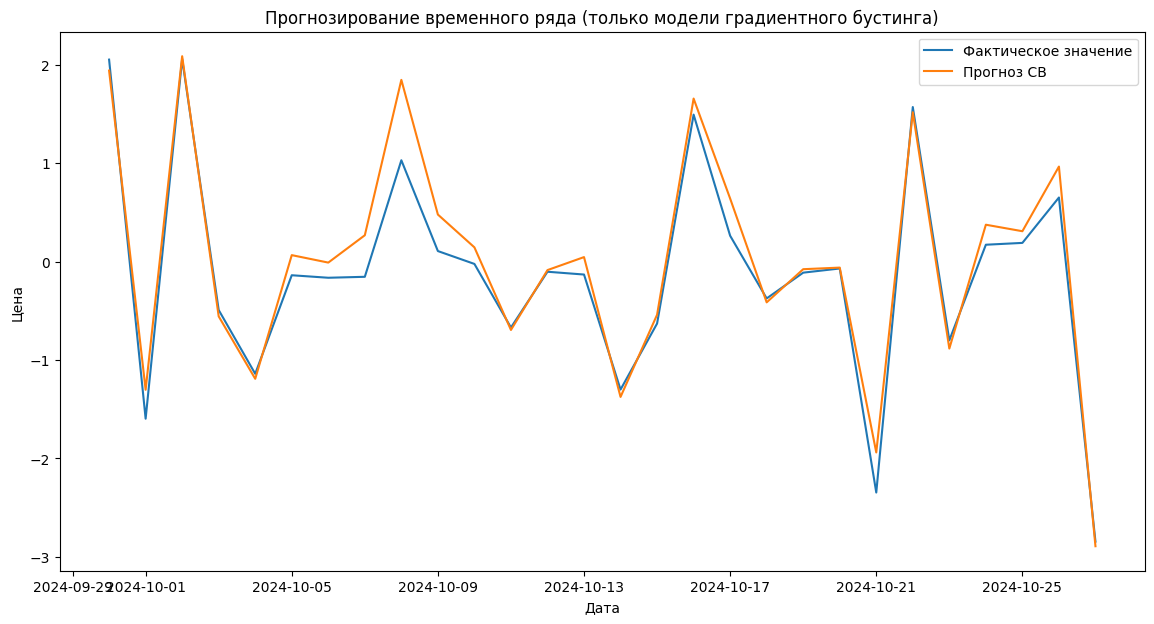

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(y_test.index, y_test, label='–§–∞–∫—Ç–∏—á–µ—Å–∫–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ')
# plt.plot(y_test.index, y_pred_xgb, label='–ü—Ä–æ–≥–Ω–æ–∑ GB', linestyle='--')
plt.plot(y_test.index, y_pred_cb, label='–ü—Ä–æ–≥–Ω–æ–∑ CB', linestyle='-')
# plt.plot(y_test.index, y_pred_lgbm, label='–ü—Ä–æ–≥–Ω–æ–∑ LGBM', linestyle=':')

plt.xlabel('–î–∞—Ç–∞')
plt.ylabel('–¶–µ–Ω–∞')
plt.title('–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Ä–µ–º–µ–Ω–Ω–æ–≥–æ —Ä—è–¥–∞ (—Ç–æ–ª—å–∫–æ –º–æ–¥–µ–ª–∏ –≥—Ä–∞–¥–∏–µ–Ω—Ç–Ω–æ–≥–æ –±—É—Å—Ç–∏–Ω–≥–∞)')
plt.legend()
plt.show()

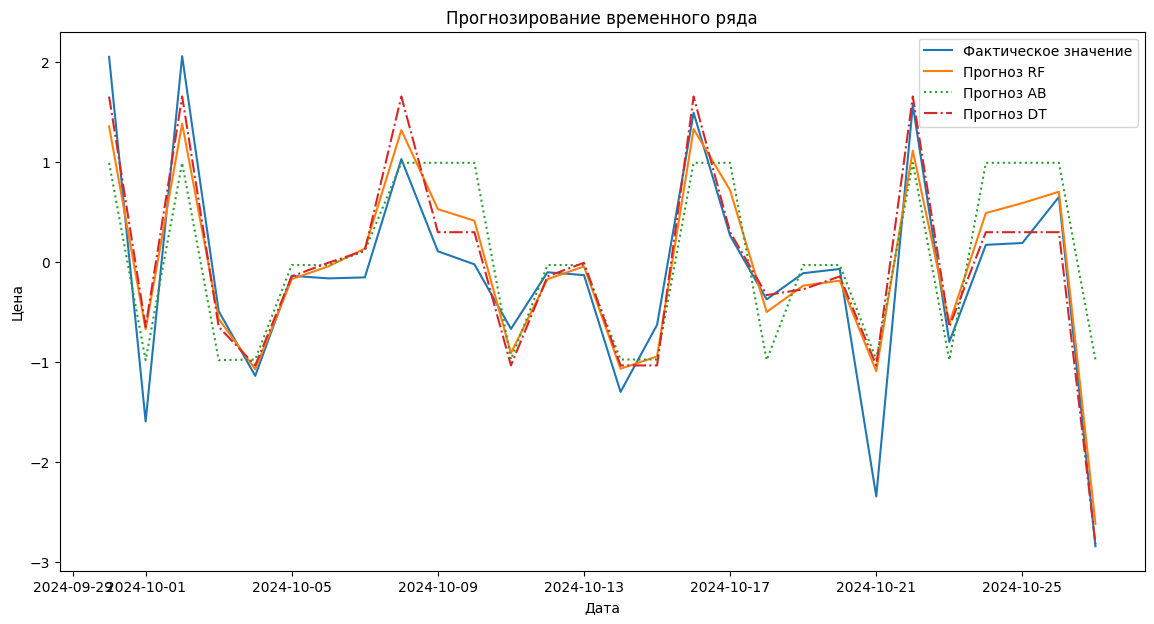

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(y_test.index, y_test, label='–§–∞–∫—Ç–∏—á–µ—Å–∫–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ')
plt.plot(y_test.index, y_pred_rf, label='–ü—Ä–æ–≥–Ω–æ–∑ RF', linestyle='-')
plt.plot(y_test.index, y_pred_ab, label='–ü—Ä–æ–≥–Ω–æ–∑ AB', linestyle=':')
plt.plot(y_test.index, y_pred_dt, label='–ü—Ä–æ–≥–Ω–æ–∑ DT', linestyle='-.')

plt.xlabel('–î–∞—Ç–∞')
plt.ylabel('–¶–µ–Ω–∞')
plt.title('–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Ä–µ–º–µ–Ω–Ω–æ–≥–æ —Ä—è–¥–∞')
plt.legend()
plt.show()

## Deep learning

### LSTM

### –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ –∏ –∫–æ–Ω—Å—Ç—Ä—É–∏—Ä–æ–≤–∞–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤


In [ ]:
def create_sequences(X, y, seq_length=10):
    X_seq = []
    y_seq = []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)


In [ ]:
df_train, df_val, df_test = split_time_series(df=df, ticker=TICKER)

df_train = extract_time_series_features(df=df_train)
df_val = extract_time_series_features(df=df_val)
df_test = extract_time_series_features(df=df_test)


df_train_processed, transformers_train = preprocess_time_series(df=df_train, target='target', is_train=True)
df_val_processed, transformers_val = preprocess_time_series(df=df_val, target='target', transformers=copy.deepcopy(transformers_train))
df_test_processed, transformers_test = preprocess_time_series(df=df_test, target='target', transformers=copy.deepcopy(transformers_train))

X_train = df_train_processed.drop(columns=['target'])
y_train = df_train_processed['target']
X_val = df_val_processed.drop(columns=['target'])
y_val = df_val_processed['target']
X_test = df_test_processed.drop(columns=['target'])
y_test = df_test_processed['target']

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

seq_length = 10
X_train_seq, y_train_seq = create_sequences(np.insert(X_train_scaled, len(X_train_scaled[0]), y_train.values, axis=1), y_train.values.reshape(-1, 1), seq_length)
X_val_seq, y_val_seq = create_sequences(np.insert(X_val_scaled, len(X_val_scaled[0]), y_val.values, axis=1), y_val.values.reshape(-1, 1), seq_length)
X_test_seq, y_test_seq = create_sequences(np.insert(X_test_scaled, len(X_test_scaled[0]), y_test.values, axis=1), y_test.values.reshape(-1, 1), seq_length)

X_train_seq = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_seq = torch.tensor(y_train_seq, dtype=torch.float32)
X_val_seq = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_seq = torch.tensor(y_val_seq, dtype=torch.float32)
X_test_seq = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_seq = torch.tensor(y_test_seq, dtype=torch.float32)

### –û–±—É—á–µ–Ω–∏–µ


In [ ]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size , output_size)


    def forward(self, x):

        lstm_out, _ = self.lstm(x)

        last_out = lstm_out[:, -1, :]

        output = self.fc(last_out)
        return output


input_size = X_train_seq.shape[2]
hidden_size = 128
output_size = 1
num_layers = 2


model = LSTMRegressor(input_size, hidden_size, output_size, num_layers)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


epochs = 30
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()


    y_pred = model(X_train_seq)


    loss = criterion(y_pred, y_train_seq)


    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


### –û—Ü–µ–Ω–∫–∞ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤

In [ ]:
y_train_real = df_train.set_index('Date')['target'].iloc[WINDOW_SIZE:]
y_val_real = df_val.set_index('Date')['target'].iloc[WINDOW_SIZE:]
y_test_real = df_test.set_index('Date')['target'].iloc[WINDOW_SIZE:]

In [ ]:
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_seq)
    val_mse_lstm = mean_squared_error(y_val_seq, y_val_pred)
    val_mae_lstm = mean_absolute_error(y_val_seq, y_val_pred)
    val_mape_lstm = mean_absolute_percentage_error(y_val_seq, y_val_pred)

print("\nValidation Results:")
print(f"MSE: {val_mse_lstm:.4f}")
print(f"MAE: {val_mae_lstm:.4f}")
print(f"MAPE: {val_mape_lstm:.4f}")


with torch.no_grad():
    y_test_pred_lstm = model(X_test_seq)
    test_mse_lstm = mean_squared_error(y_test_seq, y_test_pred_lstm)
    test_mae_lstm = mean_absolute_error(y_test_seq, y_test_pred_lstm)
    test_mape_lstm = mean_absolute_percentage_error(y_test_seq, y_test_pred_lstm)

print("\nTest Results:")
print(f"MSE: {test_mse_lstm:.4f}")
print(f"MAE: {test_mae_lstm:.4f}")
print(f"MAPE: {test_mape_lstm:.4f}")


Validation Results:
MSE: 6.7922
MAE: 1.0100
MAPE: 137347393772201.8906

Test Results:
MSE: 1.9092
MAE: 1.0672
MAPE: 3.7287


In [ ]:
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_seq)
    Y_val_real = y_val_real.values.reshape(-1, 1)[seq_length:]
    y_val_pred_real = inverse_preprocess_time_series(np.concatenate([y_val[:seq_length], y_val_pred.reshape(-1).numpy()]), transformers=transformers_val)[seq_length:]
    val_real_mse_lstm = mean_squared_error(Y_val_real, y_val_pred_real)
    val_real_mae_lstm = mean_absolute_error(Y_val_real, y_val_pred_real)
    val_real_mape_sltm = mean_absolute_percentage_error(Y_val_real, y_val_pred_real)

print("\nValidation Results:")
print(f"MSE: {val_real_mse_lstm:.4f}")
print(f"MAE: {val_real_mae_lstm:.4f}")
print(f"MAPE: {val_real_mape_sltm:.4f}")


with torch.no_grad():
    y_test_pred = model(X_test_seq)
    Y_test_real = y_test_real.values.reshape(-1, 1)[seq_length:]
    y_test_pred_real_lstm = inverse_preprocess_time_series(np.concatenate([y_test[:seq_length], y_test_pred.reshape(-1).numpy()]), transformers=transformers_test)[seq_length:]
    test_real_mse_lstm = mean_squared_error(Y_test_real, y_test_pred_real_lstm)
    test_real_mae_lstm = mean_absolute_error(Y_test_real, y_test_pred_real_lstm)
    test_real_mape_lstm = mean_absolute_percentage_error(Y_test_real, y_test_pred_real_lstm)

print("\nTest Results:")
print(f"MSE: {test_real_mse_lstm:.4f}")
print(f"MAE: {test_real_mae_lstm:.4f}")
print(f"MAPE: {test_real_mape_lstm:.4f}")


Validation Results:
MSE: 366252565678.8380
MAE: 471645.8630
MAPE: 91489262023114113024.0000

Test Results:
MSE: 753.9296
MAE: 11.7994
MAPE: 28359785474490084.0000


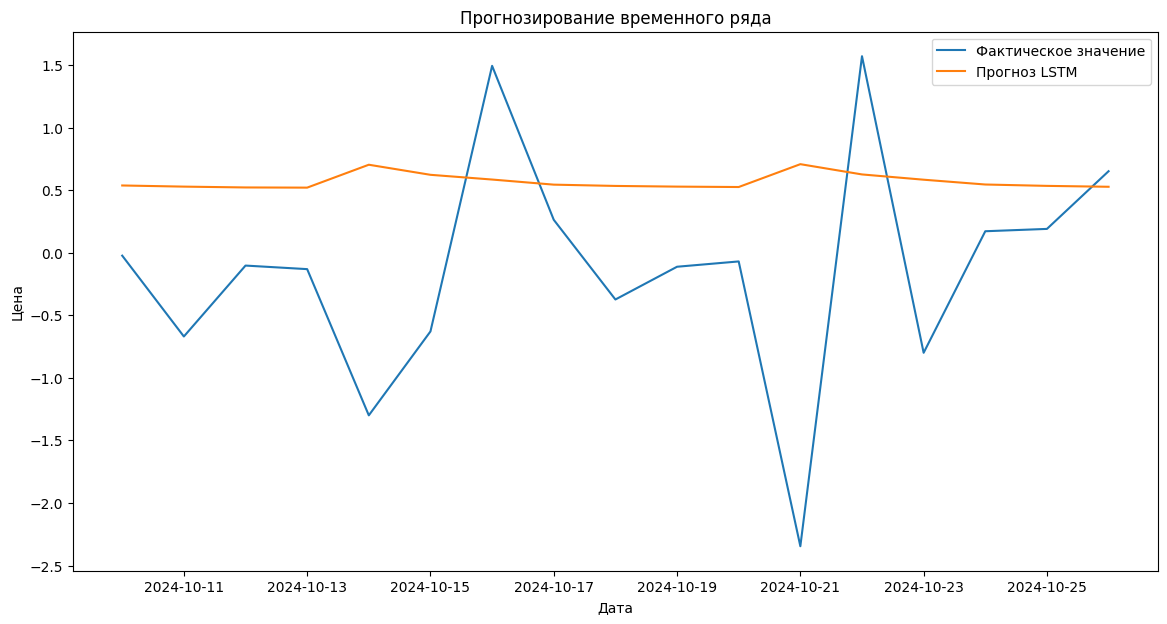

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(y_test.index[seq_length:-1], y_test[seq_length:-1], label='–§–∞–∫—Ç–∏—á–µ—Å–∫–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ')
plt.plot(y_test.index[seq_length:-1], y_test_pred_lstm[:-1], label='–ü—Ä–æ–≥–Ω–æ–∑ LSTM', linestyle='-')

plt.xlabel('–î–∞—Ç–∞')
plt.ylabel('–¶–µ–Ω–∞')
plt.title('–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Ä–µ–º–µ–Ω–Ω–æ–≥–æ —Ä—è–¥–∞')
plt.legend()
plt.show()

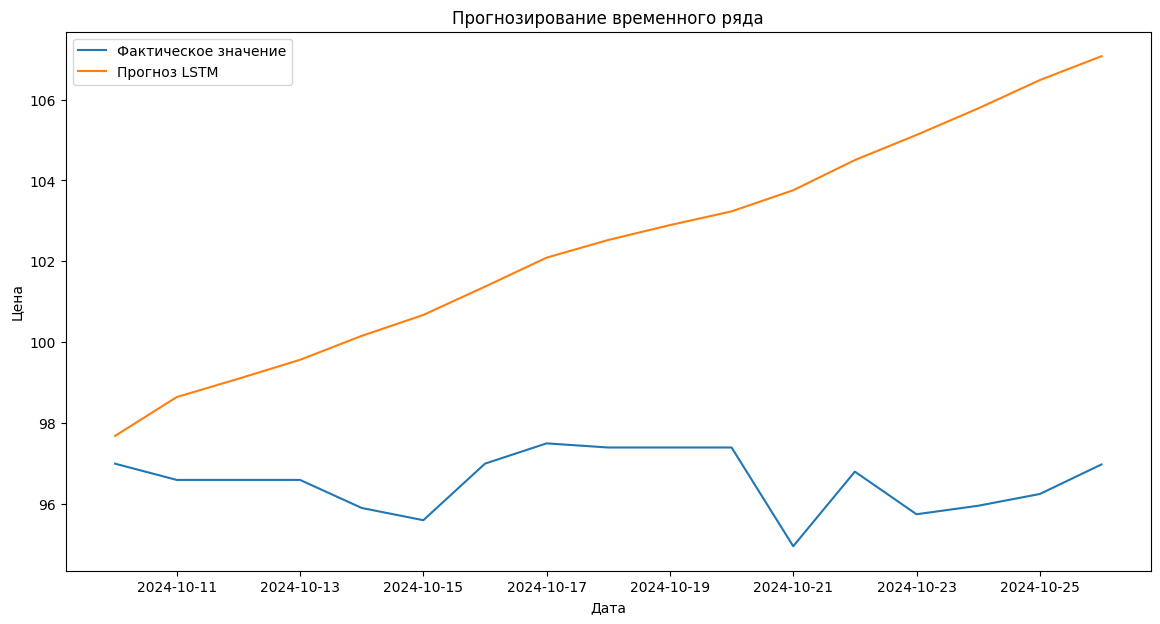

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(y_test_real.index[seq_length:-1], y_test_real[seq_length:-1], label='–§–∞–∫—Ç–∏—á–µ—Å–∫–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ')
plt.plot(y_test_real.index[seq_length:-1], y_test_pred_real_lstm[:-1], label='–ü—Ä–æ–≥–Ω–æ–∑ LSTM', linestyle='-')

plt.xlabel('–î–∞—Ç–∞')
plt.ylabel('–¶–µ–Ω–∞')
plt.title('–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Ä–µ–º–µ–Ω–Ω–æ–≥–æ —Ä—è–¥–∞')
plt.legend()
plt.show()

### TemporalFusionTransformer


### –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ –∏ –∫–æ–Ω—Å—Ç—Ä—É–∏—Ä–æ–≤–∞–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤

In [ ]:
df_train_processed, transformers_train = preprocess_time_series(df=df_train, target='target', is_train=True, do_encode=False)
df_val_processed, transformers_val = preprocess_time_series(df=df_val, target='target', transformers=copy.deepcopy(transformers_train), do_encode=False)
df_test_processed, transformers_test = preprocess_time_series(df=df_test, target='target', transformers=copy.deepcopy(transformers_train), do_encode=False)

In [ ]:
def prepare_tft_dataframe(df_processed, seq_length=10):
    df = df_processed.copy().reset_index()
    df["time_idx"] = df.groupby("ticker").cumcount()
    return df

df_train_tft = prepare_tft_dataframe(df_train_processed)
df_val_tft = prepare_tft_dataframe(df_val_processed)
df_test_tft = prepare_tft_dataframe(df_test_processed)

### –û–±—É—á–µ–Ω–∏–µ


In [ ]:
def train_and_predict_TFT(max_encoder_length=10, max_prediction_length=1):
    known_reals = [col for col in df_train_tft.columns if col not in ["target", "ticker", "time_idx"]]

    training = TimeSeriesDataSet(
        df_train_tft,
        time_idx="time_idx",
        target="target",
        group_ids=["ticker"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        static_categoricals=["ticker"],
        time_varying_known_reals=known_reals,
        time_varying_unknown_reals=["target"],
    )
    validation = TimeSeriesDataSet.from_dataset(training, df_val_tft, stop_randomization=True)
    test = TimeSeriesDataSet.from_dataset(training, df_test_tft, stop_randomization=True)

    train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=64, num_workers=0)
    test_dataloader = test.to_dataloader(train=False, batch_size=64, num_workers=0)

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints/",
        filename="best-tft",
        save_top_k=1,
        mode="min"
    )
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        patience=5,
        mode="min"
    )

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=1e-3,
        hidden_size=128,
        attention_head_size=8,
        dropout=0.1,
        loss=MeanSquaredError(),
        log_interval=10,
        reduce_on_plateau_patience=3,
        lstm_layers=2
    )

    trainer = Trainer(
        max_epochs=30,
        gradient_clip_val=0.1,
        callbacks=[checkpoint_callback, early_stop_callback]
    )

    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    best_model_path = checkpoint_callback.best_model_path
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

    return best_tft.predict(test_dataloader).cpu()


### –û—Ü–µ–Ω–∫–∞ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤

In [ ]:
seq_length = 10
y_test_pred_tft = train_and_predict_TFT().reshape(-1).numpy()
Y_test = y_test.values.reshape(-1, 1)[seq_length:]
test_mse_tft = mean_squared_error(Y_test, y_test_pred_tft)
test_mae_tft = mean_absolute_error(Y_test, y_test_pred_tft)
test_mape_tft = mean_absolute_percentage_error(Y_test, y_test_pred_tft)

print("\nTest Results:")
print(f"MSE: {test_mse_tft:.4f}")
print(f"MAE: {test_mae_tft:.4f}")
print(f"MAPE: {test_mape_tft:.4f}")

/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | lo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEV


Test Results:
MSE: 0.7298
MAE: 0.7651
MAPE: 5.3972


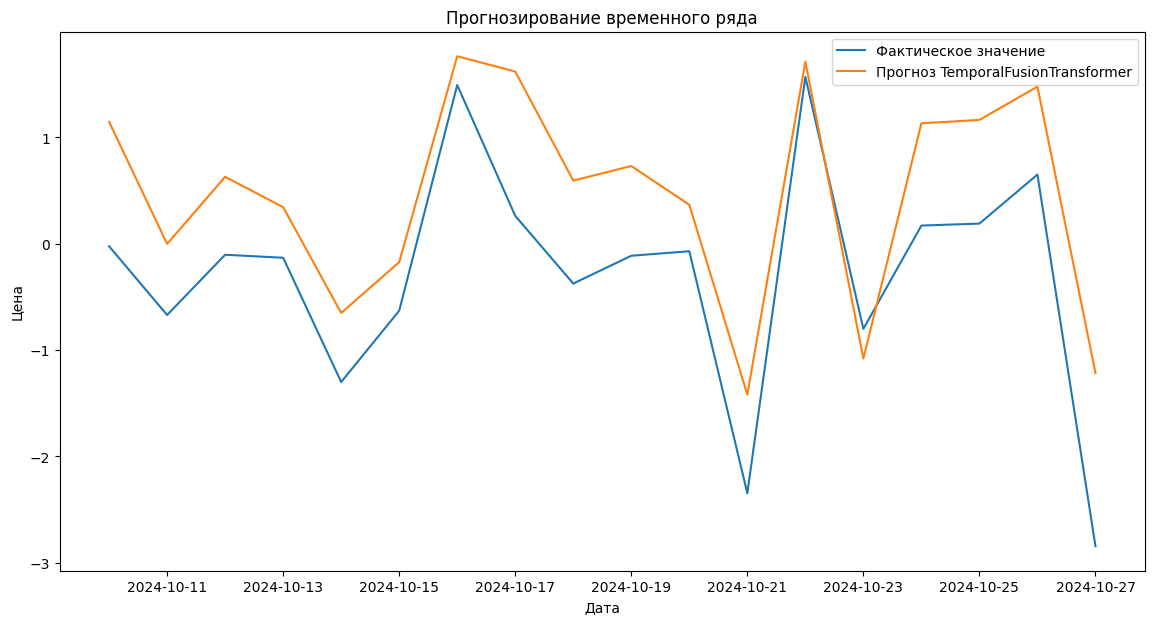

In [ ]:
seq_length = 10
plt.figure(figsize=(14, 7))

plt.plot(y_test.index[seq_length:], y_test[seq_length:], label='–§–∞–∫—Ç–∏—á–µ—Å–∫–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ')
plt.plot(y_test.index[seq_length:], y_test_pred_tft, label='–ü—Ä–æ–≥–Ω–æ–∑ TemporalFusionTransformer', linestyle='-')

plt.xlabel('–î–∞—Ç–∞')
plt.ylabel('–¶–µ–Ω–∞')
plt.title('–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Ä–µ–º–µ–Ω–Ω–æ–≥–æ —Ä—è–¥–∞')
plt.legend()
plt.show()

In [ ]:
Y_test_real = y_test_real.values.reshape(-1, 1)[seq_length:]
y_test_pred_real_tft = inverse_preprocess_time_series(np.concatenate([y_test[:seq_length], y_test_pred_tft.reshape(-1)]), transformers=transformers_test)[seq_length:]
test_real_mse_tft = mean_squared_error(Y_test_real, y_test_pred_real_tft)
test_real_mae_tft = mean_absolute_error(Y_test_real, y_test_pred_real_tft)
test_real_mape_tft = mean_absolute_percentage_error(Y_test_real, y_test_pred_real_tft)

print("\nTest Results:")
print(f"MSE: {test_real_mse_tft:.4f}")
print(f"MAE: {test_real_mae_tft:.4f}")
print(f"MAPE: {test_real_mape_tft:.4f}")


Test Results:
MSE: 236.4074
MAE: 8.5409
MAPE: 15085412081143638.0000


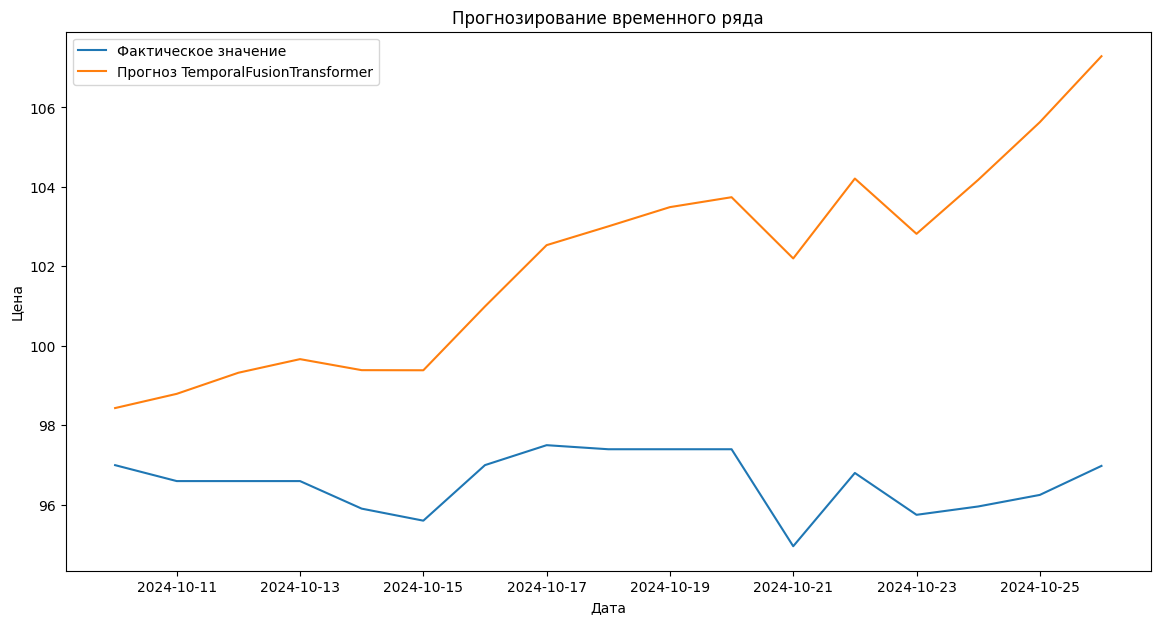

In [ ]:
seq_length = 10

y_test_real_trimmed = y_test_real[:-1]
y_test_pred_real_tft_trimmed = y_test_pred_real_tft[:-1]

plt.figure(figsize=(14, 7))

plt.plot(y_test_real_trimmed.index[seq_length:], y_test_real_trimmed[seq_length:], label='–§–∞–∫—Ç–∏—á–µ—Å–∫–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ')
plt.plot(y_test_real_trimmed.index[seq_length:], y_test_pred_real_tft_trimmed, label='–ü—Ä–æ–≥–Ω–æ–∑ TemporalFusionTransformer', linestyle='-')

plt.xlabel('–î–∞—Ç–∞')
plt.ylabel('–¶–µ–Ω–∞')
plt.title('–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Ä–µ–º–µ–Ω–Ω–æ–≥–æ —Ä—è–¥–∞')
plt.legend()
plt.show()


### –ò—Ç–µ—Ä–∞—Ç–∏–≤–Ω–æ–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ –Ω–∞ 14 –¥–Ω–µ–π –≤–ø–µ—Ä—ë–¥


In [ ]:
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting import TimeSeriesDataSet
import pandas as pd
from copy import deepcopy
import torch

best_tft = TemporalFusionTransformer.load_from_checkpoint("checkpoints/best-tft.ckpt")

best_tft.eval()
best_tft.to("cuda" if torch.cuda.is_available() else "cpu")

known_reals = [col for col in df_train_tft.columns if col not in ["target", "ticker", "time_idx"]]

training = TimeSeriesDataSet(
    df_train_tft,
    time_idx="time_idx",
    target="target",
    group_ids=["ticker"],
    max_encoder_length=10,
    max_prediction_length=1,
    static_categoricals=["ticker"],
    time_varying_known_reals=known_reals,
    time_varying_unknown_reals=["target"],
)

df_iter = deepcopy(df_test_tft[:-14])

last_time_idx = df_iter["time_idx"].max()

predictions = []

for step in range(14):
    predict_dataset = TimeSeriesDataSet.from_dataset(
        training, df_iter, predict=True, stop_randomization=True
    )
    predict_loader = predict_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

    pred = best_tft.predict(predict_loader).cpu().numpy().flatten()
    predictions.append(pred[0])

    new_rows = []

    for ticker in df_iter["ticker"].unique():
        latest_row = df_iter[df_iter["ticker"] == ticker].iloc[-1:].copy()
        latest_row["time_idx"] = last_time_idx + 1
        latest_row["target"] = pred[0]
        new_rows.append(latest_row)

    df_iter = pd.concat([df_iter] + new_rows, ignore_index=True)
    last_time_idx += 1


forecast_14 = np.array(predictions)
print("\nüìà –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –Ω–∞ 14 –¥–Ω–µ–π –≤–ø–µ—Ä—ë–¥:")
print(forecast_14)


/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/analyst/.cache/pypoetry/virtuale


üìà –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –Ω–∞ 14 –¥–Ω–µ–π –≤–ø–µ—Ä—ë–¥:
[0.34439412 0.39446962 0.41686198 0.40185174 0.34411293 0.2935982
 0.2832301  0.28599647 0.26626664 0.25534454 0.25703737 0.25698096
 0.2573138  0.25760376]


/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


## –û—Ü–µ–Ω–∫–∞ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤

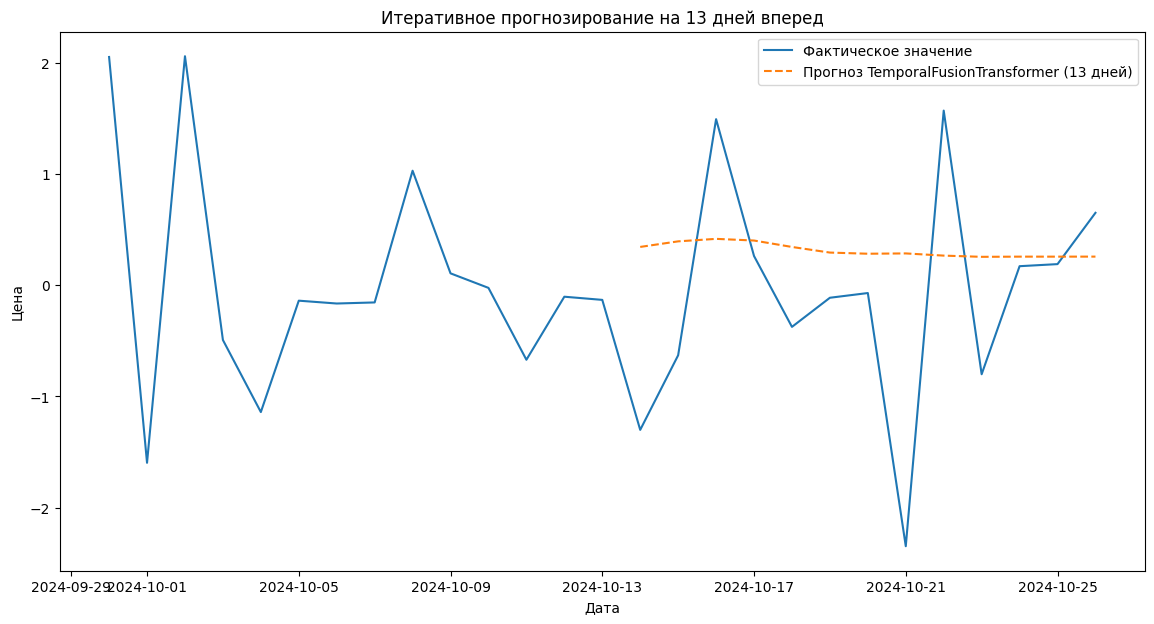

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

forecast_14 = np.array(predictions[:-1])

forecast_dates = pd.date_range(y_test.index[-14], periods=13, freq='D')
y_test_trimmed = y_test[:-1]

plt.figure(figsize=(14, 7))

plt.plot(y_test_trimmed.index, y_test_trimmed.values, label='–§–∞–∫—Ç–∏—á–µ—Å–∫–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ')

plt.plot(forecast_dates, forecast_14, label='–ü—Ä–æ–≥–Ω–æ–∑ TemporalFusionTransformer (13 –¥–Ω–µ–π)', linestyle='--')

plt.xlabel('–î–∞—Ç–∞')
plt.ylabel('–¶–µ–Ω–∞')
plt.title('–ò—Ç–µ—Ä–∞—Ç–∏–≤–Ω–æ–µ –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ –Ω–∞ 13 –¥–Ω–µ–π –≤–ø–µ—Ä–µ–¥')
plt.legend()

plt.show()


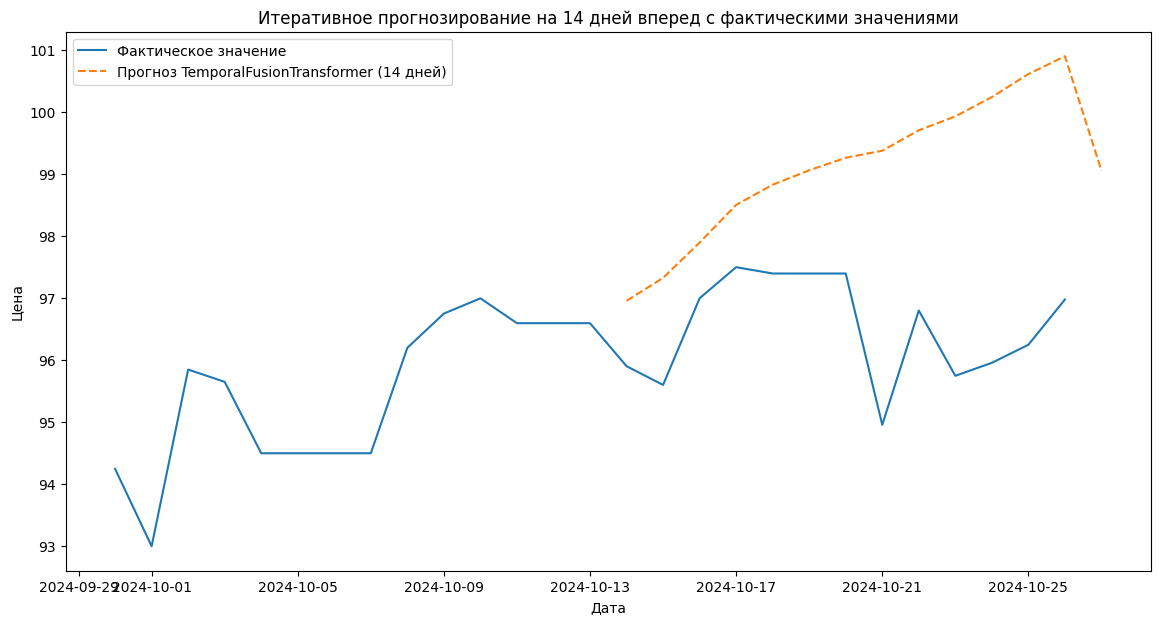

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

max_prediction_length = 14
seq_length = 10

forecast_14 = np.array(predictions)
Y_test_real = y_test_real.values.reshape(-1, 1)[-max_prediction_length:]
y_test_pred_real_two_weeks_tft = inverse_preprocess_time_series(np.concatenate([y_test[:-max_prediction_length], forecast_14]), transformers=transformers_test)[-max_prediction_length:]

forecast_dates = pd.date_range(y_test.index[-14], periods=14, freq='D')

plt.figure(figsize=(14, 7))

plt.plot(y_test_real.index[:-1], y_test_real.values[:-1], label='–§–∞–∫—Ç–∏—á–µ—Å–∫–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ')

plt.plot(forecast_dates, y_test_pred_real_two_weeks_tft, label='–ü—Ä–æ–≥–Ω–æ–∑ TemporalFusionTransformer (14 –¥–Ω–µ–π)', linestyle='--')

plt.xlabel('–î–∞—Ç–∞')
plt.ylabel('–¶–µ–Ω–∞')
plt.title('–ò—Ç–µ—Ä–∞—Ç–∏–≤–Ω–æ–µ –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ –Ω–∞ 14 –¥–Ω–µ–π –≤–ø–µ—Ä–µ–¥ —Å —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏–º–∏ –∑–Ω–∞—á–µ–Ω–∏—è–º–∏')
plt.legend()

plt.show()

## –°—Ä–∞–≤–Ω–µ–Ω–∏–µ LSTM –∏ TemporalFusionTransformer

In [ ]:
df_models = pd.DataFrame(
    data=None,
    columns=['Model', 'MSE', 'MAE', 'MAPE'],
    index=None
)

df_models.loc[1] = ['LSTM', test_mse_lstm, test_mae_lstm, test_mape_lstm]
df_models.loc[2] = ['TemporalFusionTransformer', test_mse_tft, test_mae_tft, test_mape_tft]

df_models.sort_values(by=['MSE', 'MAE', 'MAPE'], ascending=True)

Model       MSE       MAE      MAPE
2  TemporalFusionTransformer  0.729785  0.765099  5.397190
1                       LSTM  1.909195  1.067170  3.728729

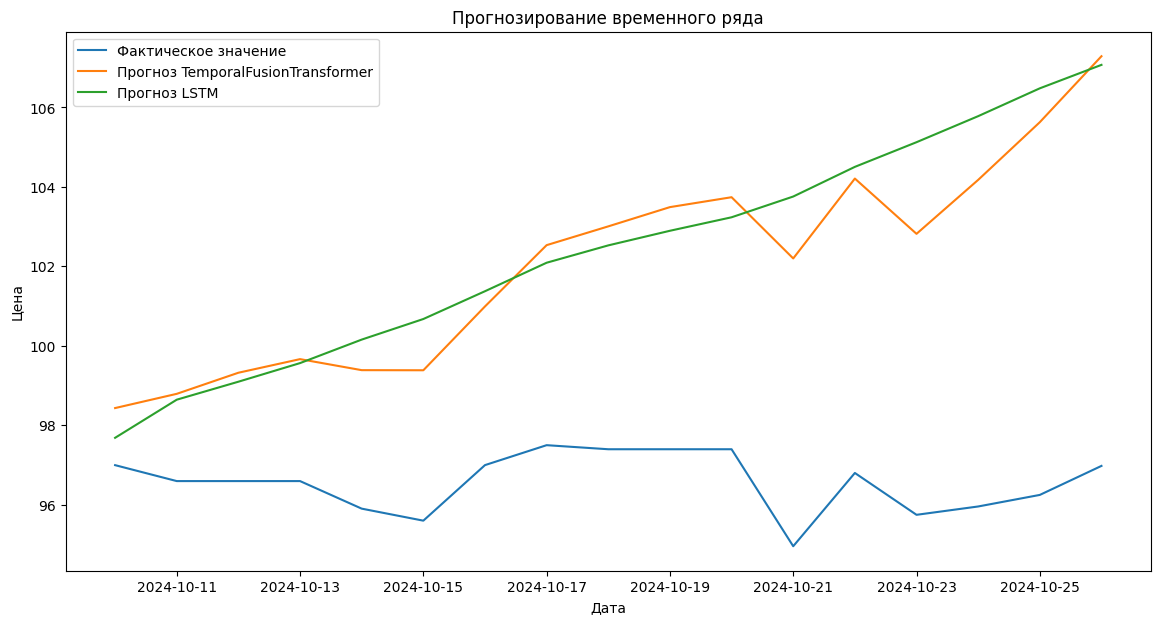

In [ ]:
seq_length = 10

y_test_real_trimmed = y_test_real[:-1]
y_test_pred_real_tft_trimmed = y_test_pred_real_tft[:-1]
y_test_pred_real_lstm_trimmed = y_test_pred_real_lstm[:-1]

plt.figure(figsize=(14, 7))

plt.plot(
    y_test_real_trimmed.index[seq_length:],
    y_test_real_trimmed[seq_length:],
    label='–§–∞–∫—Ç–∏—á–µ—Å–∫–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ'
)
plt.plot(
    y_test_real_trimmed.index[seq_length:],
    y_test_pred_real_tft_trimmed,
    label='–ü—Ä–æ–≥–Ω–æ–∑ TemporalFusionTransformer',
    linestyle='-'
)
plt.plot(
    y_test_real_trimmed.index[seq_length:],
    y_test_pred_real_lstm_trimmed,
    label='–ü—Ä–æ–≥–Ω–æ–∑ LSTM',
    linestyle='-'
)

plt.xlabel('–î–∞—Ç–∞')
plt.ylabel('–¶–µ–Ω–∞')
plt.title('–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Ä–µ–º–µ–Ω–Ω–æ–≥–æ —Ä—è–¥–∞')
plt.legend()
plt.show()
